In [3]:
'''
Network analysis metrics
'''

import requests
import urllib.request
import pathlib
import os
import shutil
import subprocess
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString, MultiPoint
import math
import folium

import geojson
import gdal
import h3

import networkx as nx

import matplotlib.pyplot as plt

import geoplot.crs as gcrs
import geoplot as gplt

tiles = {
  	"url": "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png", 
	"attribution": '',
}

from datetime import date, timedelta

import seaborn as sns

import networkit as nk

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

DIR_ROOT = os.path.join(pathlib.Path().absolute(), '../../..' )
DIR_DATA = DIR_ROOT + '/data/04_itinerary/'
DIR_OUT = DIR_ROOT + '/data/05_metrics/'
DIR_PATHS = DIR_ROOT + '/data/03_paths/'

paths = gpd.read_file(DIR_PATHS + 'paths.geojson').to_dict('records')
activities_df = pd.read_csv(DIR_DATA + 'activities.csv')

stays_df = pd.read_csv(DIR_DATA + 'stays.csv')
stays_df['geometry'] = stays_df['geometry'].apply(wkt.loads)
stays_df.set_index('locality', inplace=True)
stays_df['locality'] = stays_df.index

stays_geo = gpd.GeoDataFrame(stays_df, crs='epsg:4326').set_geometry('geometry')

localities = stays_geo[stays_geo['domestic'] == True].groupby(level=0).first()
localities['name'] = localities.index

bbox = stays_geo.buffer(1).total_bounds

<ipython-input-3-361f7d75fea4>:64: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox = stays_geo.buffer(1).total_bounds


In [4]:
edges = []
for this_stay_no in range(len(stays_df) - 1):
    this_stay = stays_df.iloc[this_stay_no]
    next_stay = stays_df.iloc[this_stay_no + 1]

    if this_stay['locality'] != next_stay['locality']:
        locality_from = this_stay['locality'] if this_stay['locality'] < next_stay['locality'] else next_stay['locality']
        locality_to = this_stay['locality'] if this_stay['locality'] > next_stay['locality'] else next_stay['locality']

        edges.append(
            {
                "f": locality_from,
                "t": locality_to,
                "domestic": next_stay['domestic'] == True,
                "period1": next_stay['period1'],
                "period2": next_stay['period2'],
                "period3": next_stay['period3'],
                "period4": next_stay['period4'],
                "period5": next_stay['period5'],
                "periodall": True,
            }
        )

periods = ['1', '2', '3', '4', '5', 'all']

In [7]:
eigens = []
infos = []
closes = []
between = []

for period in periods:

    G = nx.Graph()
    
    for i1, l1 in localities.iterrows():
        for i2, l2 in localities.iterrows():
            if i1 > i2:
                es = [
                    e for e in edges if (e['f'] == i2) & (e['t'] == i1) & (e['domestic'] == True) & (e['period' + period] == True)
                ]
                if len(es) > 0:
                    distance = next(path for path in paths if path['from'] == l1['name'] and path['to'] == l2['name'])
                    G.add_edge(i1, i2, weight=len(es), distance=float(distance['dist']))

    between.append(pd.DataFrame(list(
        nx.algorithms.betweenness_centrality(G, weight="weight").items()
    ), columns=['name', 'p' + period]).set_index('name'))
    
    closes.append(pd.DataFrame(list(
        nx.algorithms.closeness_centrality(G, distance="distance", wf_improved=True).items()
    ), columns=['name', 'p' + period]).set_index('name'))

    eigens.append(pd.DataFrame(list(
        nx.algorithms.eigenvector_centrality(G, weight="weight").items()
    ), columns=['name', 'p' + period]).set_index('name'))

    infos.append(pd.DataFrame(list(
        nx.algorithms.information_centrality(G, weight="weight").items()
    ), columns=['name', 'p' + period]).set_index('name'))


    print('p{} processed'.format(period))

p1 processed
p2 processed
p3 processed
p4 processed
p5 processed
pall processed


In [9]:
localities

,Unnamed: 0,from_date,to_date,days,domestic,geometry,no_activities,period1,period2,period3,period4,period5,locality,name
locality,,,,,,,,,,,,,,
Beroun,158,1265-06-17,1265-07-01,14,True,POINT (14.07000 49.96000),1,False,False,True,False,False,Beroun,Beroun
Bratislava,32,1254-04-22,1254-04-26,4,True,POINT (17.10000 48.14000),1,False,True,False,False,False,Bratislava,Bratislava
Brno,35,1254-05-22,1254-06-15,24,True,POINT (16.61000 49.19000),1,False,True,False,False,False,Brno,Brno
Budyně nad Ohří,133,1262-05-29,1262-06-12,14,True,POINT (14.13000 50.40000),2,False,False,True,False,False,Budyně nad Ohří,Budyně nad Ohří
Cheb,168,1266-04-17,1266-05-05,18,True,POINT (12.38000 50.07000),1,False,False,True,False,False,Cheb,Cheb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zvíkov,78,1258-04-20,1258-05-15,25,True,POINT (14.19000 49.44000),1,False,True,False,False,False,Zvíkov,Zvíkov
Zwettl,96,1259-11-28,1259-12-14,16,True,POINT (15.17000 48.61000),1,False,True,False,False,False,Zwettl,Zwettl
České Budějovice,159,1265-07-06,1265-07-31,25,True,POINT (14.47000 48.97000),1,False,False,True,False,False,České Budějovice,České Budějovice


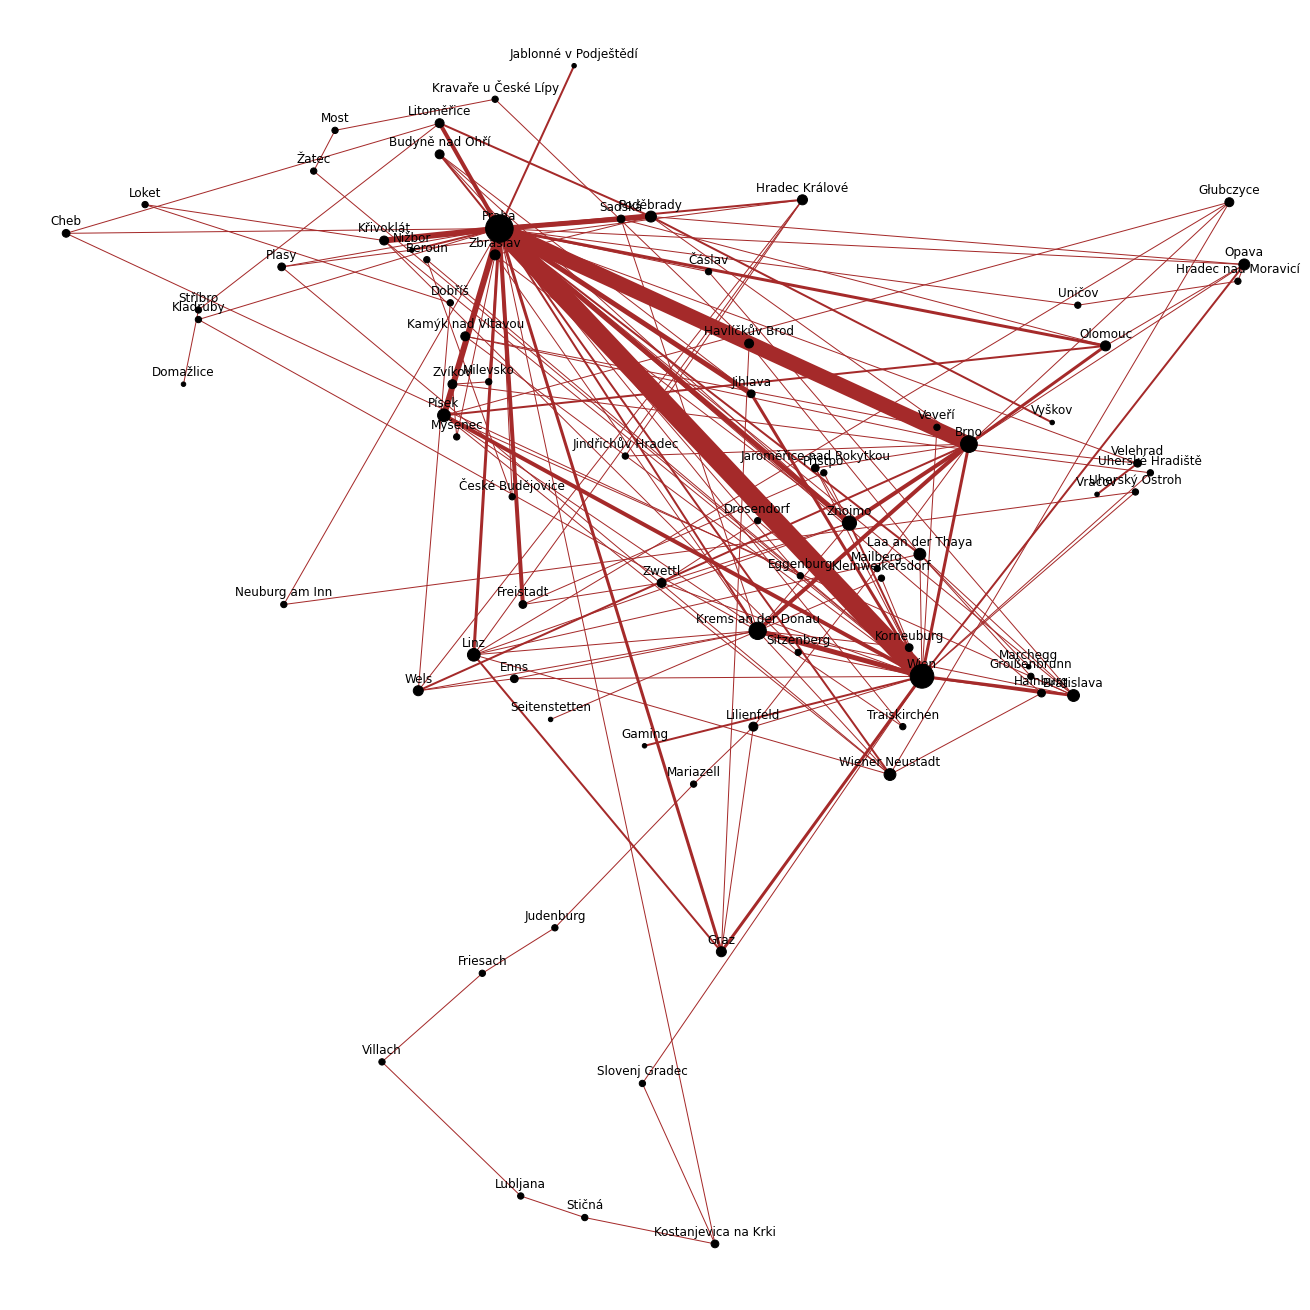

In [35]:
labels_pos = {name: [geo.x, geo.y + 0.05] for (name, geo) in localities[['geometry']].itertuples()}
node_pos = {name: [geo.x, geo.y] for (name, geo) in localities[['geometry']].itertuples()}
edge_weights = nx.get_edge_attributes(G,'weight').values()
node_degree = nx.degree(G)

plt.figure(figsize=(18,18))
nx.draw(G, pos=node_pos, width=list(edge_weights), node_size=[v[1] * 20 for v in node_degree], node_color='black', edge_color="brown")
nx.draw_networkx_labels(G, pos=labels_pos)
plt.show()

In [37]:
closes_df = gpd.GeoDataFrame(
    pd.concat(closes + [localities['geometry']], axis=1, join="outer"),
    crs='epsg:4326'
)

eigen_df = gpd.GeoDataFrame(
    pd.concat(eigens + [localities['geometry']], axis=1, join="outer"),
    crs='epsg:4326'
)

info_df = gpd.GeoDataFrame(
    pd.concat(infos + [localities['geometry']], axis=1, join="outer"),
    crs='epsg:4326'
)

between_df = gpd.GeoDataFrame(
    pd.concat(between + [localities['geometry']], axis=1, join="outer"),
    crs='epsg:4326'
)

closes_df.to_csv(DIR_OUT + 'centr_closes.csv')
eigen_df.to_csv(DIR_OUT + 'centr_eigen.csv')
info_df.to_csv(DIR_OUT + 'centr_infos.csv')
between_df.to_csv(DIR_OUT + 'centr_between.csv')

In [3]:
def create_map():
    m = folium.Map(tiles='Stamen Toner', dragging=False, zooming=False)

    m.fit_bounds([[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
    return m

def create_circle(radius, geometry, tooltip):
    return folium.CircleMarker(
        radius=radius,
        location=[geometry.y, geometry.x], 
        tooltip=tooltip,   
        weight=1,
        color="red",
        fill="red",
    )

In [4]:
map = create_map()

for location_name, r in closes_df.iterrows():
    create_circle(
        r['pall'] * 100, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

In [5]:
map = create_map()

for location_name, r in eigen_df.iterrows():
    create_circle(
        r['pall'] * 30 + 3, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

In [6]:
map = create_map()

for location_name, r in info_df.iterrows():
    create_circle(
        r['pall'] * 400, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map